In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [3]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
abundance_df = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [5]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [6]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [7]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [8]:
# gpmap_binding_DM = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
# gpmap_binding_EE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# gpmap_abundance = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

gpmap_blackbox = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



In [9]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [12]:
def model_local(gpmap, 
                mp,
                x_train,
                y_train):
    
    model = mavenn.Model2(gpmap=gpmap,
                          mp_list=[mp])
    
    # Set training data
    model.set_data(x=x_train.values,
                   y_list=[y_train.values],
                   shuffle=True)
    
    return model
    

In [13]:
mp_DM = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                               Y=Y,
                                                               K=50,
                                                               eta=1e-5,)


mp_EE = mavenn.measurement_process_layers.ExponentialEnrichmentMP(Y=Y,
                                                                  t_y=[0,1],
                                                                  eta=1e-5,
                                                                  info_for_layers_dict={'H_y_norm':0})


In [14]:
model_binding_DM = model_local(gpmap_blackbox,mp_DM, x_train, y_train)
#model_binding_EE = model_local(gpmap_binding_EE,mp_EE, x_train, y_train)

2022-06-15 22:47:45.783754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


N = 38,449 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 1.54 sec.


In [12]:
# # Set training data
# model.set_data(x=x_train.values,
#                y_list=[y_train.values],
#                shuffle=True)


In [13]:
# from tensorflow.keras.utils import plot_model
# plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='lehner.png')

In [14]:

# Fit model to data
model_binding_DM.fit(learning_rate=.0005,
                     epochs=300,
                     batch_size=300,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=False,
                     early_stopping_patience=10,
                     linear_initialization=False)

# model_binding_EE.fit(learning_rate=.0005,
#                      epochs=300,
#                      batch_size=300,
#                      try_tqdm = False,
#                      early_stopping=False,
#                      verbose=False,
#                      early_stopping_patience=10,
#                      linear_initialization=False)

Training time: 128.0 seconds
Training time: 106.2 seconds


On test data:


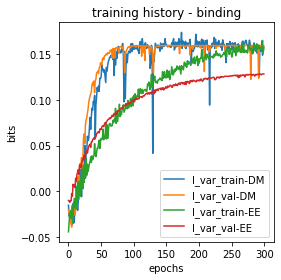

In [15]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_binding_DM.history['I_var']
val_I_var_hist = model_binding_DM.history['val_I_var']

fig, ax = plt.subplots(figsize=[4,4])

ax.plot(I_var_hist, label='I_var_train-DM')
ax.plot(val_I_var_hist, label='I_var_val-DM')
#ax.set_xscale('log')
ax.set_title('training history - binding')

I_var_hist = model_binding_EE.history['I_var']
val_I_var_hist = model_binding_EE.history['val_I_var']

ax.plot(I_var_hist, label='I_var_train-EE')
ax.plot(val_I_var_hist, label='I_var_val-EE')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/training_history_binding.png',dpi=200,bbox_inches='tight')


In [16]:
phi_DM = gpmap_binding_DM.x_to_phi(x_test)
phi_EE = gpmap_binding_EE.x_to_phi(x_test)

In [47]:
theta_lc_DM = gpmap_binding_DM.get_theta(model_binding_DM,gauge='consensus')['theta_lc']
theta_lc_EE = gpmap_binding_EE.get_theta(model_binding_EE,gauge='consensus')['theta_lc']
theta_lc_consensus_EE_df = pd.DataFrame(theta_lc_EE,columns=alphabet)
theta_lc_consensus_DM_df = pd.DataFrame(theta_lc_DM,columns=alphabet)

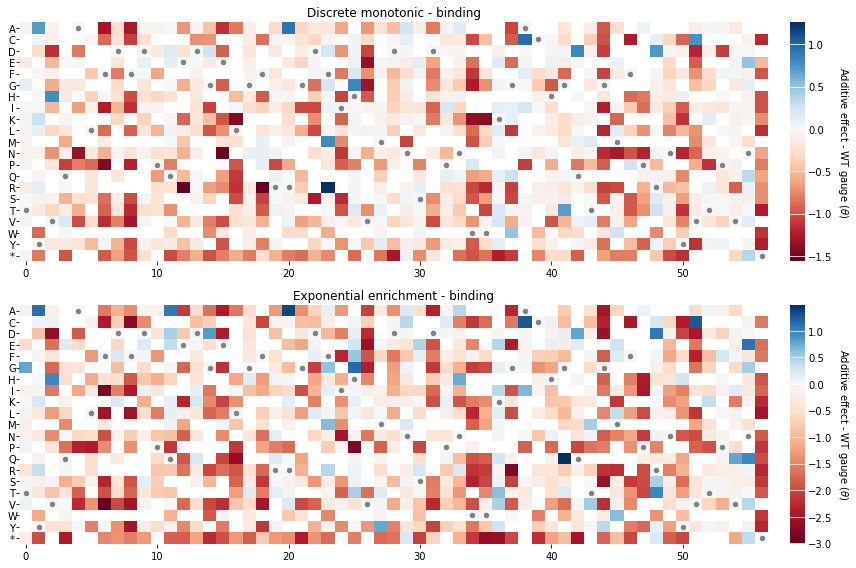

In [60]:

# # Create fig and ax objects
fig, axs = plt.subplots(2,1, figsize=[12,8])

ax = axs[0]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_DM,
                        alphabet=alphabet,
                        seq=model_binding_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Discrete monotonic - binding')

ax = axs[1]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_EE,
                        alphabet=alphabet,
                        seq=model_binding_EE.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Exponential enrichment - binding')


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/GP_map_binding.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Theta exponential enrichment')

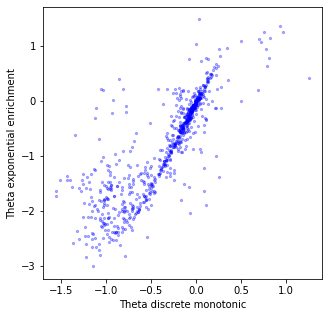

In [37]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_EE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta exponential enrichment')

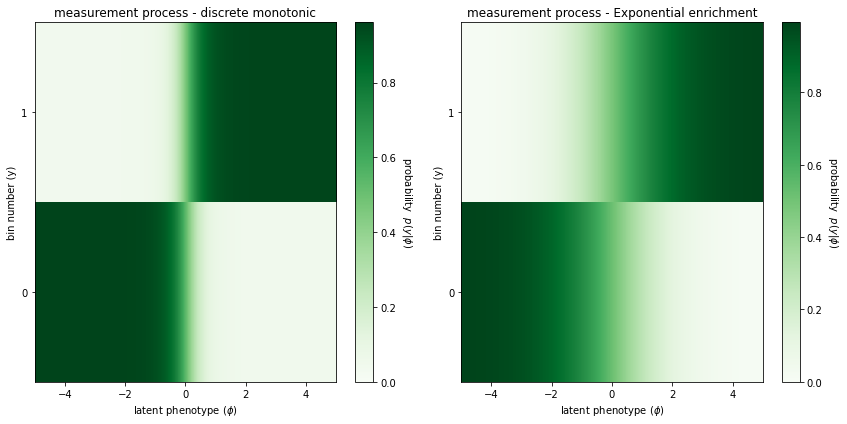

In [19]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_DM.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,6])

ax = axs[0]
# Right panel: draw measurement process as heatmap

measurement_process = mp_DM.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

ax = axs[1]
# Right panel: draw measurement process as heatmap

measurement_process = mp_EE.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - Exponential enrichment')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/lehner_measurment_prcoess_binding.png',dpi=300,bbox_inches='tight')


In [10]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

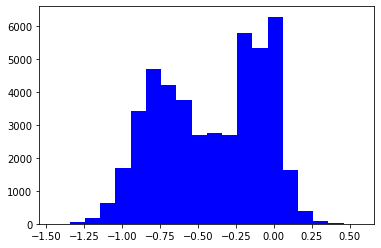

In [11]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [12]:
#gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=50,
                                                           monotonic=True,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [13]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [14]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

2022-06-15 22:49:08.872040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


N = 41,749 observations set as training data.
Using 20.1% for validation.
Time to set data: 1.51 sec.


In [15]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/150
112/112 [==============================] - 2s 6ms/step - loss: 309.1432 - I_var: -1.2571 - val_loss: 285.1463 - val_I_var: -1.1436
Epoch 2/150
112/112 [==============================] - 0s 3ms/step - loss: 262.6713 - I_var: -1.0332 - val_loss: 233.9544 - val_I_var: -0.8992
Epoch 3/150
112/112 [==============================] - 0s 3ms/step - loss: 214.6288 - I_var: -0.8022 - val_loss: 194.8990 - val_I_var: -0.7114
Epoch 4/150
112/112 [==============================] - 0s 4ms/step - loss: 179.7261 - I_var: -0.6344 - val_loss: 163.5043 - val_I_var: -0.5606
Epoch 5/150
112/112 [==============================] - 0s 3ms/step - loss: 149.3939 - I_var: -0.4888 - val_loss: 134.5616 - val_I_var: -0.4220
Epoch 6/150
112/112 [==============================] - 0s 3ms/step - loss: 121.7640 - I_var: -0.3552 - val_loss: 109.4758 - val_I_var: -0.3020
Epoch 7/150
112/112 [==============================] - 0s 3ms/step - loss: 96.4546 - I_var: -0.2343 - val_loss: 83.2832 - val_I_var: -0.1760
E

112/112 [==============================] - 0s 4ms/step - loss: -208.3712 - I_var: 1.2315 - val_loss: -158.6539 - val_I_var: 1.0061
Epoch 59/150
112/112 [==============================] - 1s 5ms/step - loss: -206.9247 - I_var: 1.2247 - val_loss: -158.3735 - val_I_var: 1.0010
Epoch 60/150
112/112 [==============================] - 0s 3ms/step - loss: -209.2354 - I_var: 1.2377 - val_loss: -162.2672 - val_I_var: 1.0235
Epoch 61/150
112/112 [==============================] - 0s 3ms/step - loss: -210.3528 - I_var: 1.2415 - val_loss: -161.0830 - val_I_var: 1.0160
Epoch 62/150
112/112 [==============================] - 0s 3ms/step - loss: -210.3942 - I_var: 1.2434 - val_loss: -156.0593 - val_I_var: 0.9851
Epoch 63/150
112/112 [==============================] - 0s 4ms/step - loss: -208.9273 - I_var: 1.2381 - val_loss: -156.6366 - val_I_var: 0.9978
Epoch 64/150
112/112 [==============================] - 1s 5ms/step - loss: -210.6870 - I_var: 1.2462 - val_loss: -154.5930 - val_I_var: 0.9818
Epoch

Epoch 115/150
112/112 [==============================] - 0s 4ms/step - loss: -217.0205 - I_var: 1.2766 - val_loss: -155.5941 - val_I_var: 0.9879
Epoch 116/150
112/112 [==============================] - 0s 3ms/step - loss: -216.2712 - I_var: 1.2720 - val_loss: -161.2860 - val_I_var: 1.0229
Epoch 117/150
112/112 [==============================] - 1s 5ms/step - loss: -217.2949 - I_var: 1.2702 - val_loss: -158.8479 - val_I_var: 1.0089
Epoch 118/150
112/112 [==============================] - 0s 3ms/step - loss: -216.7185 - I_var: 1.2692 - val_loss: -141.7277 - val_I_var: 0.9282
Epoch 119/150
112/112 [==============================] - 0s 4ms/step - loss: -215.4952 - I_var: 1.2651 - val_loss: -152.0784 - val_I_var: 0.9721
Epoch 120/150
112/112 [==============================] - 0s 4ms/step - loss: -217.3375 - I_var: 1.2770 - val_loss: -159.0161 - val_I_var: 1.0132
Epoch 121/150
112/112 [==============================] - 0s 4ms/step - loss: -216.6541 - I_var: 1.2721 - val_loss: -157.2469 - val

On test data:


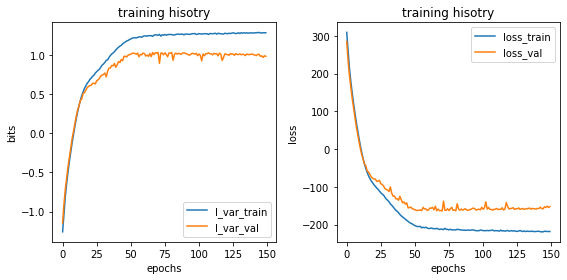

In [16]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [19]:
phi = gpmapGE.x_to_phi(x_test_GE)
phi_train = gpmapGE.x_to_phi(x_train_GE)

In [21]:
np.corrcoef(phi_train,y_train_GE)[0,1]**2

0.8789714107448623

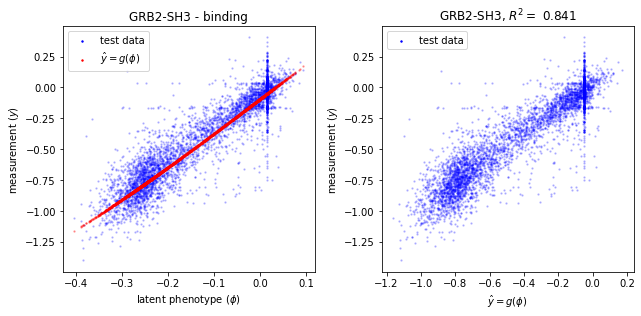

In [18]:
fig, axs = plt.subplots(1,2, figsize=(9,4.5))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(phi,yhat,s=2,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GRB2-SH3 - binding')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_binding_binding.png',dpi=300,bbox_inches='tight')    


In [30]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

Text(0, 0.5, 'Theta global epistasis')

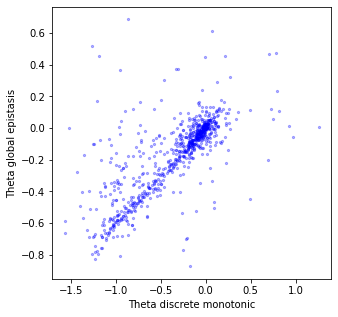

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta global epistasis')

In [48]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv')
lehner_binding_singles_df

,Unnamed: 0,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,1,T,K,NaN,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,2181.666667,0.010464,0.005995
1,2,1,T,N,NaN,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,16.000000,0.028944,0.087284
2,3,2,Y,K,NaN,TKVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,23.000000,-0.093964,0.092442
3,4,2,Y,N,NaN,TNVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,8892.666667,-0.035080,0.004516
4,5,2,Y,S,NaN,TSVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,54.666667,0.044625,0.027825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,707,1,T,A,NaN,AYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,11058.666667,-0.013506,0.004341
707,708,1,T,G,NaN,GYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,14.000000,-0.012349,0.071471
708,709,1,T,V,NaN,VYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,57.000000,-0.002641,0.028864
709,710,1,T,*,NaN,*YVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,True,False,15.000000,-0.219692,0.074135


In [50]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

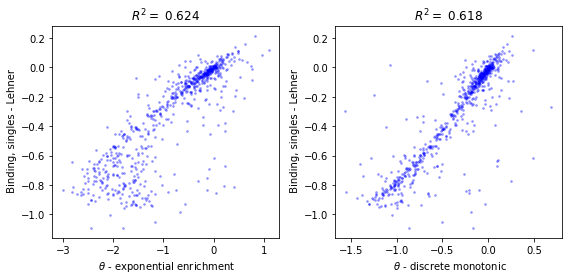

In [58]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_lc_consensus_EE_df.fillna(0).values.ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_EE_df.values.ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - exponential enrichment')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_consensus_DM_df.fillna(0).values.ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_DM_df.values.ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - discrete monotonic')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


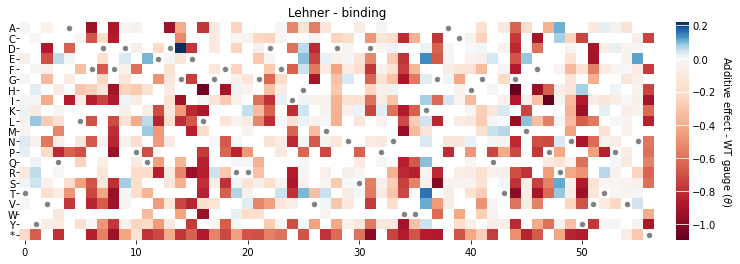

In [59]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model_binding_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')